In [1]:
import os 

epochs = [20, 50, 100]

In [2]:
os.listdir('20/')

['Deconvolution_attributions.pt',
 'DeepLiftShap_attributions.pt',
 'InputXGradient_attributions.pt',
 'IG_attributions.pt',
 'Saliency_attributions.pt',
 'DeepLift_attributions.pt',
 'GuidedBackprop_attributions.pt',
 'GradientShap_attributions.pt']

In [3]:
import torch

def load_attrs(epoch):
    ig = torch.load(f'{epoch}/IG_attributions.pt')
#     gs = torch.load(f'{epoch}/GradientShap_attributions.pt')
    
    dl = torch.load(f'{epoch}/DeepLift_attributions.pt')
#     dls = torch.load(f'{epoch}/DeepLiftShap_attributions.pt')
    
    s = torch.load(f'{epoch}/Saliency_attributions.pt')
    ixg = torch.load(f'{epoch}/InputXGradient_attributions.pt')
    
    dc = torch.load(f'{epoch}/Deconvolution_attributions.pt')
    gbp = torch.load(f'{epoch}/GuidedBackprop_attributions.pt')

    return [ig, dl, dc, ixg, s, gbp]

In [4]:
import numpy as np

def process_attr(attributions):
    # C, H, W -> H, W, C
    attributions = attributions[0].permute(1,2,0).detach().cpu().numpy()

    # flattern to 1D
    attributions = np.sum(np.abs(attributions), axis=-1)

    # normalise attributions to [0,1]
    attributions -= np.min(attributions)
    attributions /= np.max(attributions)

    return attributions

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def sim_mat_show(processed_attrs):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    matrix = cosine_similarity(np.stack(processed_attrs))
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if i > j:
                matrix[i][j] = 0
    im = ax.imshow(matrix, cmap='Purples', vmin=0.0, vmax=1.0)
    labels = ['IG', 'DL', 'Dec', 'IxG', 'Sal', 'GBp']
    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)
    ax.xaxis.set_ticks_position("top")
    fig.colorbar(im)
    plt.show()

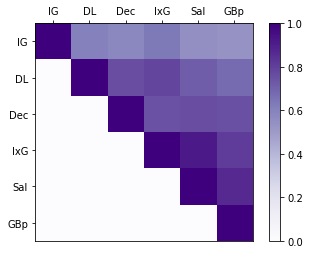

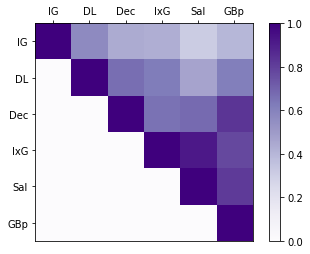

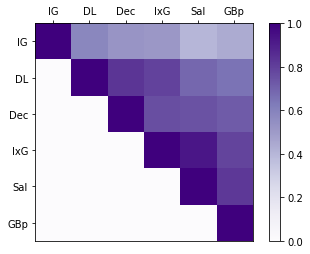

In [6]:
attrs = load_attrs(epochs[0])
average_mat = np.zeros((len(epochs), len(attrs) + 1))

for i in range(len(epochs)):
    epoch = epochs[i]
    attrs = load_attrs(epoch)
    processed_attrs = [process_attr(attr).reshape((-1)) for attr in attrs]
    sim_mat = cosine_similarity(np.stack(processed_attrs))
    average_mat[i][0] = (np.sum(sim_mat) - len(attrs))/ (len(attrs)**2 - len(attrs))
    for j in range(len(sim_mat)):
        average_mat[i][j+1] = ((np.sum(sim_mat[j]) - 1)/(len(attrs) - 1))
    sim_mat_show(processed_attrs)

In [7]:
average_mat

array([[0.71109186, 0.57742894, 0.70688107, 0.71860574, 0.7774549 ,
        0.75896282, 0.72721772],
       [0.61234281, 0.42813428, 0.58714821, 0.65400095, 0.68043842,
        0.6378353 , 0.68649972],
       [0.677977  , 0.49047048, 0.70775887, 0.71482884, 0.75484924,
        0.71584275, 0.6841118 ]])

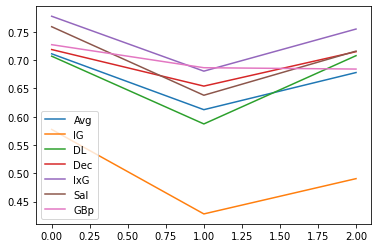

In [8]:
labels = ['Avg', 'IG', 'DL', 'Dec', 'IxG', 'Sal', 'GBp']
for i in range(len(average_mat[0])):
    plt.plot(np.arange(len(epochs)), average_mat[:,i], label=labels[i])
plt.legend()

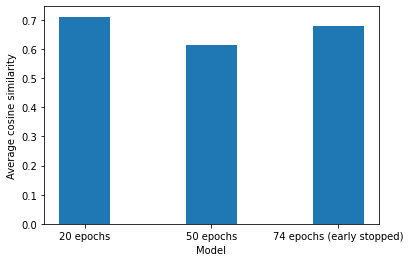

In [22]:
plt.bar([0,2,4], list(average_mat[:,0]))
plt.xlabel("Model")
plt.xticks([0,2,4], ["20 epochs", "50 epochs", "74 epochs (early stopped)"])
plt.ylabel("Average cosine similarity")
plt.show()